## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking to make purchases.

In [2]:
# import necessary libraries

import pandas as pd
import pandas.util.testing as tm #remove errors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


In [3]:
# import dataset

data = pd.read_csv('kc_house_data.csv')

In [4]:
# look at dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# look at price to get a sense of what we want to predict and its distribution, etc.
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

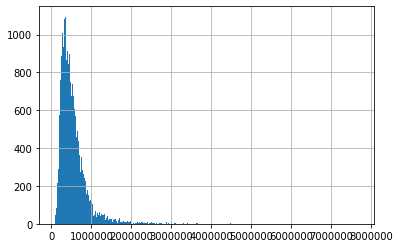

In [6]:
data['price'].hist(bins='auto')

75% of houses in the dataset are 645K or less. As an investor, looking to value houses for entry in the market, will be more focused on houses less than $1M (will go farther and allow money to go to work more)

In [7]:
# remove all houses with prices greater than $1M
houses_data = data.loc[data['price'] <= 1000000]

In [8]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20139 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20139 non-null  int64  
 1   date           20139 non-null  object 
 2   price          20139 non-null  float64
 3   bedrooms       20139 non-null  int64  
 4   bathrooms      20139 non-null  float64
 5   sqft_living    20139 non-null  int64  
 6   sqft_lot       20139 non-null  int64  
 7   floors         20139 non-null  float64
 8   waterfront     17912 non-null  float64
 9   view           20082 non-null  float64
 10  condition      20139 non-null  int64  
 11  grade          20139 non-null  int64  
 12  sqft_above     20139 non-null  int64  
 13  sqft_basement  20139 non-null  object 
 14  yr_built       20139 non-null  int64  
 15  yr_renovated   16562 non-null  float64
 16  zipcode        20139 non-null  int64  
 17  lat            20139 non-null  float64
 18  long  

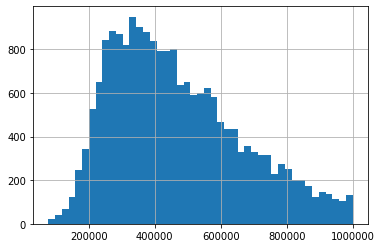

In [9]:
# look at the histogram
houses_data['price'].hist(bins='auto')

In [10]:
houses_data['price'].describe()

count      20139.000000
mean      467970.857441
std       196495.025672
min        78000.000000
25%       314700.000000
50%       435000.000000
75%       594000.000000
max      1000000.000000
Name: price, dtype: float64

The median house price is still relatively inline with where it was before removing the upper set of houses

In [11]:
houses_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
# remove ID column as it is not relevant
houses_data = houses_data.drop(columns='id')

In [13]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20139 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20139 non-null  object 
 1   price          20139 non-null  float64
 2   bedrooms       20139 non-null  int64  
 3   bathrooms      20139 non-null  float64
 4   sqft_living    20139 non-null  int64  
 5   sqft_lot       20139 non-null  int64  
 6   floors         20139 non-null  float64
 7   waterfront     17912 non-null  float64
 8   view           20082 non-null  float64
 9   condition      20139 non-null  int64  
 10  grade          20139 non-null  int64  
 11  sqft_above     20139 non-null  int64  
 12  sqft_basement  20139 non-null  object 
 13  yr_built       20139 non-null  int64  
 14  yr_renovated   16562 non-null  float64
 15  zipcode        20139 non-null  int64  
 16  lat            20139 non-null  float64
 17  long           20139 non-null  float64
 18  sqft_l

In [15]:
# handle missing values - - waterfront, yr_renovated are the only columns missing values
houses_data['waterfront'].nunique()

2

In [16]:
houses_data['waterfront'].unique()

array([nan,  0.,  1.])

In [17]:
# check how many are missing
houses_data['waterfront'].isna().sum()

2227

In [18]:
# 11% of the data is NaN, don't want to drop this many rows - - set all NaNs as 0

In [19]:
# assuming that NaNs in the waterfront column are related to houses that do not have waterfront
# will relabel all NaNs as 0
houses_data['waterfront'] = houses_data['waterfront'].fillna(value=0.)

In [20]:
# check there are no more missing values
houses_data['waterfront'].isna().any()

False

In [21]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20139 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20139 non-null  object 
 1   price          20139 non-null  float64
 2   bedrooms       20139 non-null  int64  
 3   bathrooms      20139 non-null  float64
 4   sqft_living    20139 non-null  int64  
 5   sqft_lot       20139 non-null  int64  
 6   floors         20139 non-null  float64
 7   waterfront     20139 non-null  float64
 8   view           20082 non-null  float64
 9   condition      20139 non-null  int64  
 10  grade          20139 non-null  int64  
 11  sqft_above     20139 non-null  int64  
 12  sqft_basement  20139 non-null  object 
 13  yr_built       20139 non-null  int64  
 14  yr_renovated   16562 non-null  float64
 15  zipcode        20139 non-null  int64  
 16  lat            20139 non-null  float64
 17  long           20139 non-null  float64
 18  sqft_l

In [22]:
# look at yr_renovated
houses_data['yr_renovated'].nunique()

70

In [23]:
houses_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2013., 1994., 1978., 2005., 2003.,
       1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988., 1977.,
       1981., 1995., 2000., 1999., 1970., 1989., 2004., 1986., 2007.,
       1987., 1985., 2001., 1980., 1992., 1971., 1979., 1997., 2010.,
       1950., 1969., 1948., 2009., 2006., 2015., 1974., 2008., 2012.,
       1968., 1963., 1951., 1962., 1953., 1993., 1998., 1996., 1955.,
       1982., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1956., 1967., 1965., 1934., 1972., 1944., 1958.])

In [24]:
# fill NaNs with 0.
houses_data['yr_renovated'] = houses_data['yr_renovated'].fillna(value=0.)

In [25]:
# should be no more missing values
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view              True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [26]:
# view is missing some values - - how many are missing?
houses_data['view'].isna().sum()

57

In [27]:
# only 57 are missing - - remove all entries without view
houses_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [28]:
houses_data = houses_data.dropna()

In [29]:
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [30]:
# no more missing values - - check for duplicates
houses_data.duplicated().any()

False

In [31]:
# no duplicates

In [32]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20082 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20082 non-null  object 
 1   price          20082 non-null  float64
 2   bedrooms       20082 non-null  int64  
 3   bathrooms      20082 non-null  float64
 4   sqft_living    20082 non-null  int64  
 5   sqft_lot       20082 non-null  int64  
 6   floors         20082 non-null  float64
 7   waterfront     20082 non-null  float64
 8   view           20082 non-null  float64
 9   condition      20082 non-null  int64  
 10  grade          20082 non-null  int64  
 11  sqft_above     20082 non-null  int64  
 12  sqft_basement  20082 non-null  object 
 13  yr_built       20082 non-null  int64  
 14  yr_renovated   20082 non-null  float64
 15  zipcode        20082 non-null  int64  
 16  lat            20082 non-null  float64
 17  long           20082 non-null  float64
 18  sqft_l

In [33]:
# handle strings - - convert to appropriate types
houses_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '?', '730.0', '1700.0', '300.0', '970.0',
       '760.0', '700.0', '820.0', '780.0', '790.0', '330.0', '1620.0',
       '360.0', '1510.0', '410.0', '990.0', '600.0', '560.0', '550.0',
       '1000.0', '500.0', '1040.0', '880.0', '1010.0', '240.0', '265.0',
       '290.0', '800.0', '540.0', '840.0', '380.0', '480.0', '570.0',
       '1490.0', '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0',
       '1130.0', '450.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '390.0', '430.0', '210.0',
       '440.0', '220.0', '1160.0', '860.0', '580.0', '2060.0', '1180.0',
       '200.0', '1150.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0',
       '960.0', '870.0', '280.0', '1200.0', '1100.0', '460.0', '770.0',
       '1400.0', '720.0', '660.0', '1220.0', '900.0', '420.0', '1580.0',
       '1380.0', '475.0', '690.0', '270.0', '350.0', '1370.0', '850.0',
       '1470.0', '160.0', '950.0', '50.0', '740.0', '710.0

In [34]:
# need to remove the entries with ?
# check how many there are
houses_data.loc[houses_data['sqft_basement'] == '?'].count()

date             422
price            422
bedrooms         422
bathrooms        422
sqft_living      422
sqft_lot         422
floors           422
waterfront       422
view             422
condition        422
grade            422
sqft_above       422
sqft_basement    422
yr_built         422
yr_renovated     422
zipcode          422
lat              422
long             422
sqft_living15    422
sqft_lot15       422
dtype: int64

In [35]:
# only 422 entries out of 20,000 - - remove these
houses_data = houses_data.loc[houses_data['sqft_basement'] != '?']

In [36]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19660 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19660 non-null  object 
 1   price          19660 non-null  float64
 2   bedrooms       19660 non-null  int64  
 3   bathrooms      19660 non-null  float64
 4   sqft_living    19660 non-null  int64  
 5   sqft_lot       19660 non-null  int64  
 6   floors         19660 non-null  float64
 7   waterfront     19660 non-null  float64
 8   view           19660 non-null  float64
 9   condition      19660 non-null  int64  
 10  grade          19660 non-null  int64  
 11  sqft_above     19660 non-null  int64  
 12  sqft_basement  19660 non-null  object 
 13  yr_built       19660 non-null  int64  
 14  yr_renovated   19660 non-null  float64
 15  zipcode        19660 non-null  int64  
 16  lat            19660 non-null  float64
 17  long           19660 non-null  float64
 18  sqft_l

In [37]:
# now need to convert basement column to a number format
houses_data['sqft_basement'] = houses_data['sqft_basement'].astype('float64')

In [38]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19660 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19660 non-null  object 
 1   price          19660 non-null  float64
 2   bedrooms       19660 non-null  int64  
 3   bathrooms      19660 non-null  float64
 4   sqft_living    19660 non-null  int64  
 5   sqft_lot       19660 non-null  int64  
 6   floors         19660 non-null  float64
 7   waterfront     19660 non-null  float64
 8   view           19660 non-null  float64
 9   condition      19660 non-null  int64  
 10  grade          19660 non-null  int64  
 11  sqft_above     19660 non-null  int64  
 12  sqft_basement  19660 non-null  float64
 13  yr_built       19660 non-null  int64  
 14  yr_renovated   19660 non-null  float64
 15  zipcode        19660 non-null  int64  
 16  lat            19660 non-null  float64
 17  long           19660 non-null  float64
 18  sqft_l

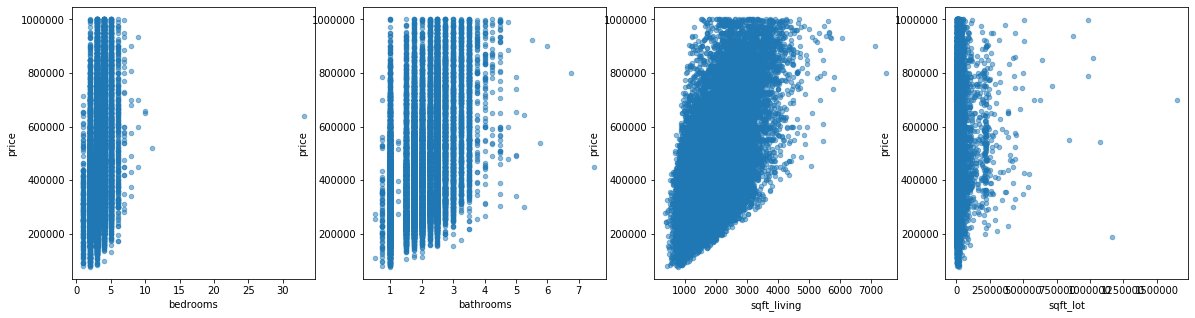

In [39]:
# now the only string column we have is the date column
# begin visualizations and plotting against price to see which may be solid predictors to begin with and 
# which may need log normalization, etc.
# will need to normalize / scale
# will need to split cat and continuous variables

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], axes):
    houses_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

In [40]:
# only two houses that are greater than 10 bedrooms so remove these
houses_data = houses_data.loc[houses_data['bedrooms'] <= 10]

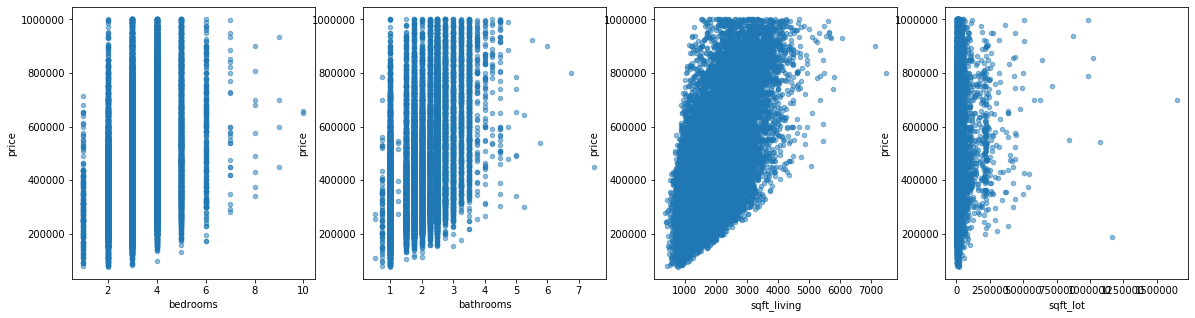

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], axes):
    houses_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.5)

plt.show()

In [42]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19658 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19658 non-null  object 
 1   price          19658 non-null  float64
 2   bedrooms       19658 non-null  int64  
 3   bathrooms      19658 non-null  float64
 4   sqft_living    19658 non-null  int64  
 5   sqft_lot       19658 non-null  int64  
 6   floors         19658 non-null  float64
 7   waterfront     19658 non-null  float64
 8   view           19658 non-null  float64
 9   condition      19658 non-null  int64  
 10  grade          19658 non-null  int64  
 11  sqft_above     19658 non-null  int64  
 12  sqft_basement  19658 non-null  float64
 13  yr_built       19658 non-null  int64  
 14  yr_renovated   19658 non-null  float64
 15  zipcode        19658 non-null  int64  
 16  lat            19658 non-null  float64
 17  long           19658 non-null  float64
 18  sqft_l

In [43]:
"""
Function to plot y vs. a chosen set of x variables
"""

def plot_x_y(x_vals, y_val):
    fig, axes = plt.subplots(nrows = 1, ncols=len(x_vals), figsize=(20,5))
    for xcol, ax in zip(x_vals, axes):
        houses_data.plot(kind='scatter', x=xcol, y=y_val, ax=ax, alpha=0.5)
    plt.tight_layout()
    plt.show()

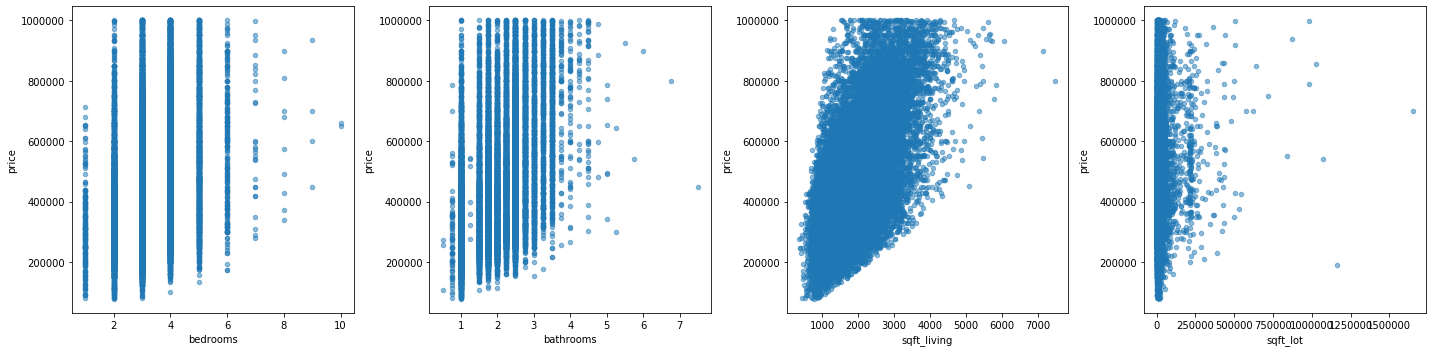

In [44]:
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

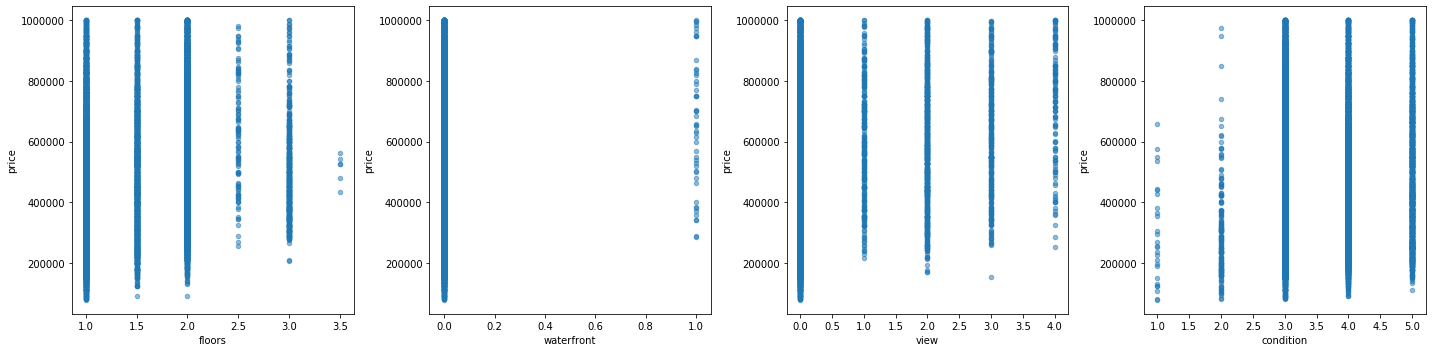

In [45]:
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')

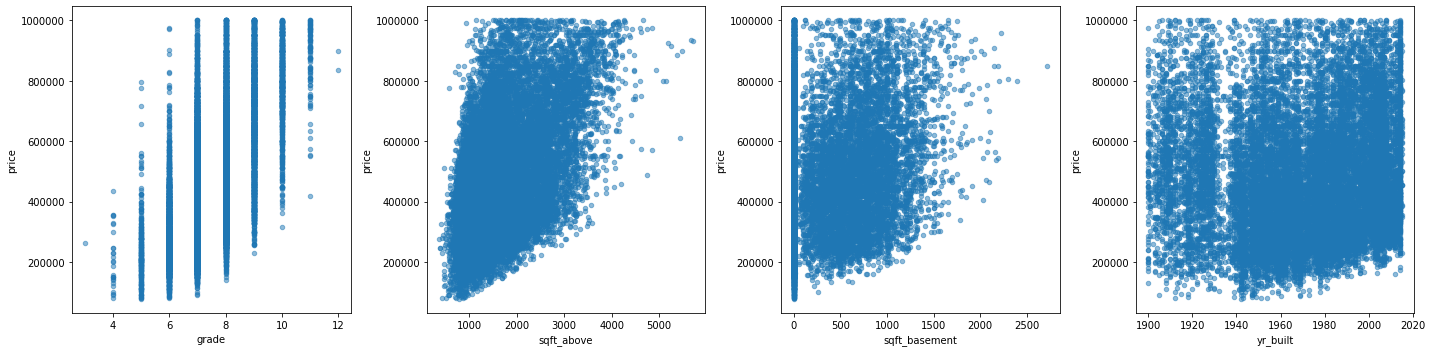

In [46]:
plot_x_y(['grade', 'sqft_above', 'sqft_basement', 'yr_built'], 'price')

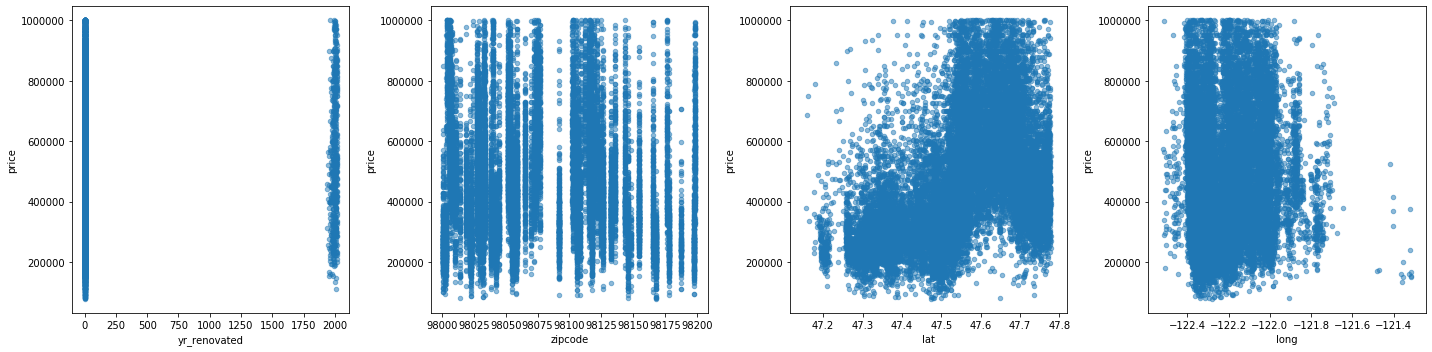

In [47]:
plot_x_y(['yr_renovated', 'zipcode', 'lat', 'long'], 'price')

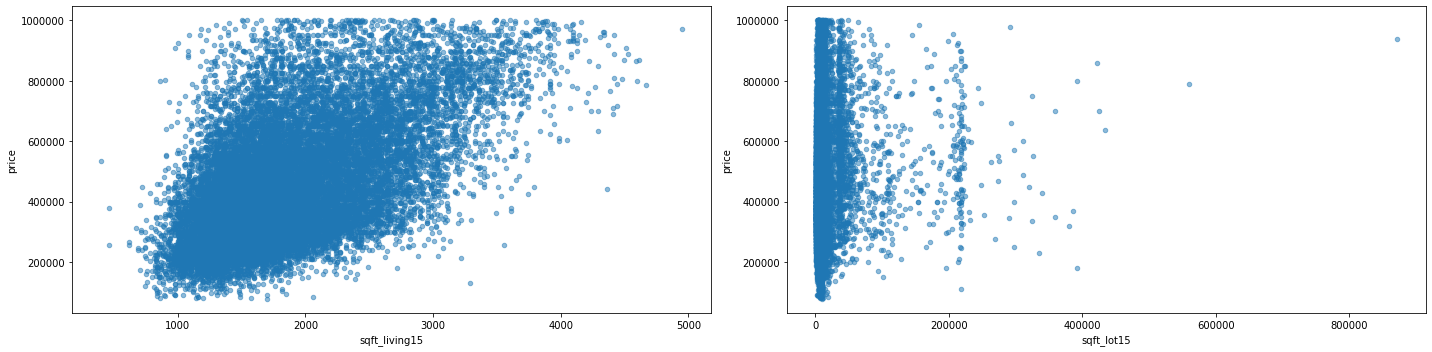

In [48]:
plot_x_y(['sqft_living15', 'sqft_lot15'], 'price')

In [49]:
# there are a number of outliers - - try to clean some of this up
# check how many entries have a sqft lot greater than 500K
houses_data['sqft_lot'].describe()

count    1.965800e+04
mean     1.451796e+04
std      4.012317e+04
min      5.200000e+02
25%      5.000000e+03
50%      7.500000e+03
75%      1.026000e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [50]:
houses_data.loc[houses_data['sqft_lot'] >= 500000].count()

date             18
price            18
bedrooms         18
bathrooms        18
sqft_living      18
sqft_lot         18
floors           18
waterfront       18
view             18
condition        18
grade            18
sqft_above       18
sqft_basement    18
yr_built         18
yr_renovated     18
zipcode          18
lat              18
long             18
sqft_living15    18
sqft_lot15       18
dtype: int64

In [51]:
# only 18 entries - - let's remove these and see if this helps
houses_data = houses_data.loc[houses_data['sqft_lot'] < 500000]

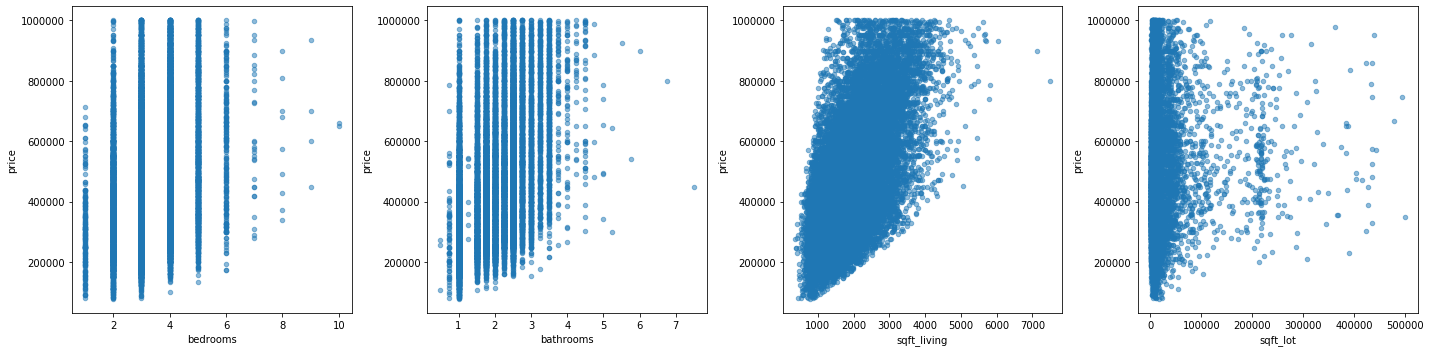

In [52]:
# look at visualizations one more time
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

In [53]:
# clear continuouse variables from these plots appear to be sqft_living, sqft_lot, sqft_above, sqft_basement,
# lat, and long - - it also seems like there may be some polynomial relationship between lat and price
cont_variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']

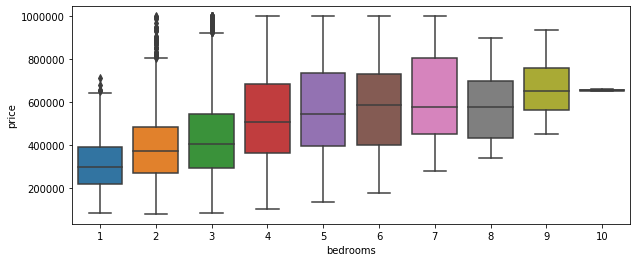

In [54]:
# evaluate other columns for ordinal relationships - if ordinal, will treat as a single column, otherwise 
# create dummy vars
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bedrooms', y='price', data=houses_data)

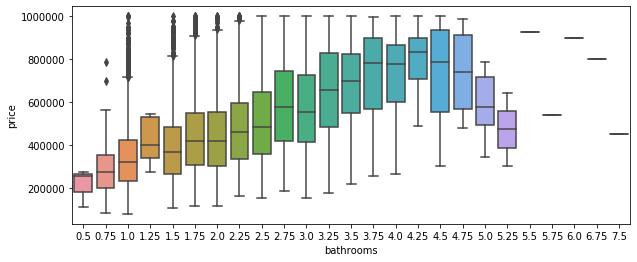

In [55]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bathrooms', y='price', data=houses_data)
plt.show()

In [56]:
# how many houses have more than 5 bathrooms
houses_data.loc[houses_data['bathrooms'] > 5].count()

date             7
price            7
bedrooms         7
bathrooms        7
sqft_living      7
sqft_lot         7
floors           7
waterfront       7
view             7
condition        7
grade            7
sqft_above       7
sqft_basement    7
yr_built         7
yr_renovated     7
zipcode          7
lat              7
long             7
sqft_living15    7
sqft_lot15       7
dtype: int64

In [57]:
# only 7 --  remove these entries
houses_data = houses_data.loc[houses_data['bathrooms'] <= 5]

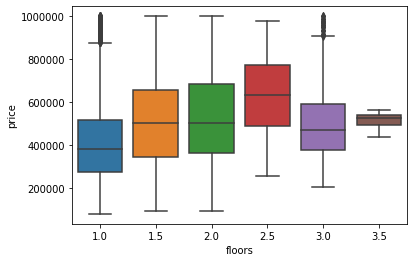

In [58]:
ax = sns.boxplot(x='floors', y='price', data=houses_data)

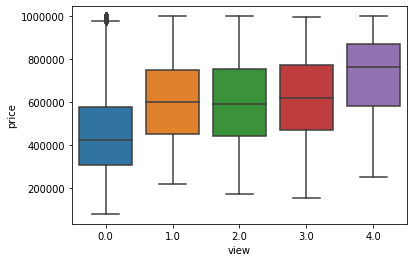

In [59]:
ax = sns.boxplot(x='view', y='price', data=houses_data)

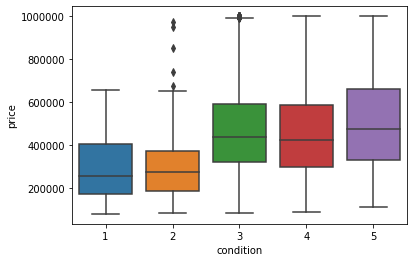

In [60]:
ax = sns.boxplot(x='condition', y='price', data=houses_data)

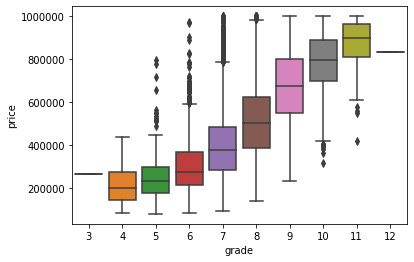

In [61]:
ax = sns.boxplot(x='grade', y='price', data=houses_data)

In [62]:
# how many have a grade of 12?
houses_data.loc[houses_data['grade'] >= 12].count()

date             1
price            1
bedrooms         1
bathrooms        1
sqft_living      1
sqft_lot         1
floors           1
waterfront       1
view             1
condition        1
grade            1
sqft_above       1
sqft_basement    1
yr_built         1
yr_renovated     1
zipcode          1
lat              1
long             1
sqft_living15    1
sqft_lot15       1
dtype: int64

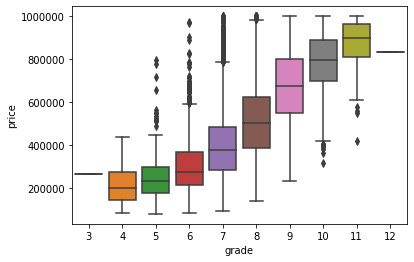

In [63]:
ax = sns.boxplot(x='grade', y='price', data=houses_data)

In [64]:
# only 1 entry --  remove this
houses_data = houses_data.loc[houses_data['grade'] < 12]

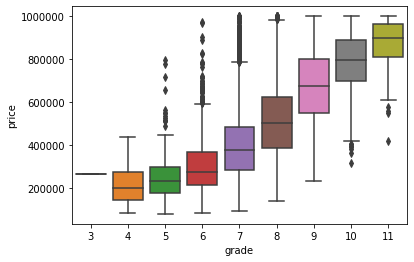

In [65]:
ax = sns.boxplot(x='grade', y='price', data=houses_data)

In [66]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [67]:
# check for multicollinearity and remove where necessary
data_pred = houses_data.iloc[:, 2:]
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


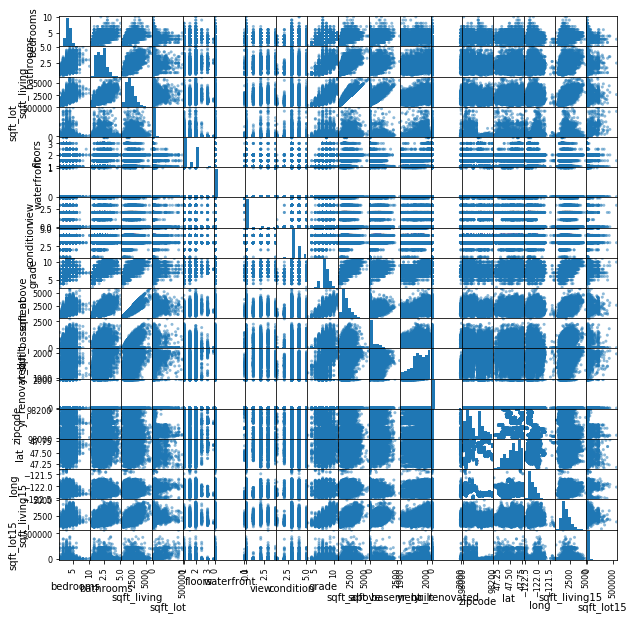

In [162]:
# scatter matrix to evaluate collinearity
pd.plotting.scatter_matrix(data_pred, figsize=(10, 10))
plt.show()

In [68]:
abs(data_pred.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [69]:
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)


In [70]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.849321
"(sqft_lot, sqft_lot15)",0.778824


In [71]:
# remove sqft_above and sqft_lot15 given high correlation

In [72]:
houses_data.drop(['sqft_above', 'sqft_lot15'], axis=1, inplace=True)

In [73]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15'],
      dtype='object')

In [74]:
# categorical columns prior to any preprocessing
cat_origin = houses_data[['bathrooms', 'floors', 'condition', 'waterfront', 'view']]
ordinal_cat = houses_data[['grade', 'bedrooms']]

In [75]:
cat_origin.head()

,bathrooms,floors,condition,waterfront,view
0,1.00,1.0,3,0.0,0.0
1,2.25,2.0,3,0.0,0.0
2,1.00,1.0,3,0.0,0.0
3,3.00,1.0,5,0.0,0.0
4,2.00,1.0,3,0.0,0.0


In [76]:
ordinal_cat.head()

,grade,bedrooms
0,7,3
1,7,3
2,6,2
3,7,4
4,8,3


In [77]:
bath_dummies = pd.get_dummies(cat_origin['bathrooms'], prefix='bath', drop_first=True)
floor_dummies = pd.get_dummies(cat_origin['floors'], prefix='floor', drop_first=True)
cond_dummies = pd.get_dummies(cat_origin['condition'], prefix='cond', drop_first=True)
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)
view_dummies = pd.get_dummies(cat_origin['view'], prefix='view', drop_first=True)

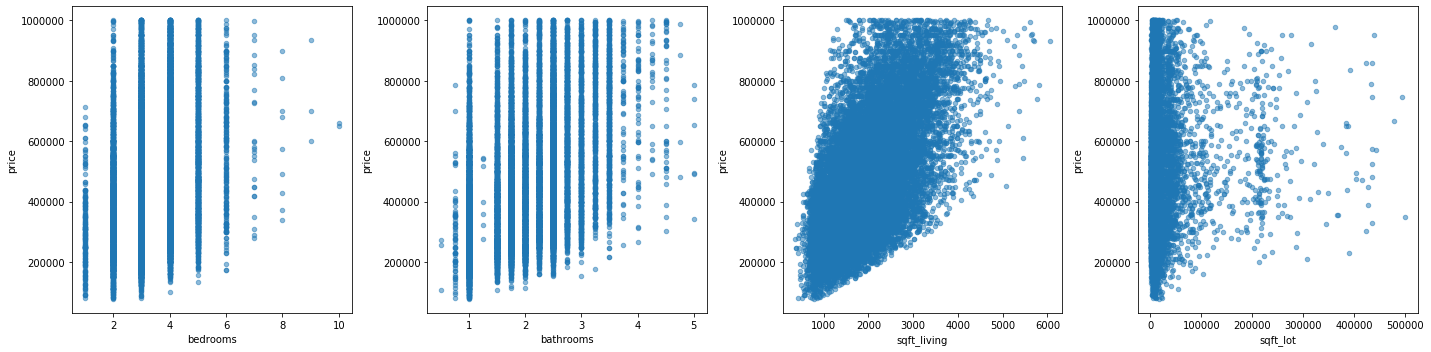

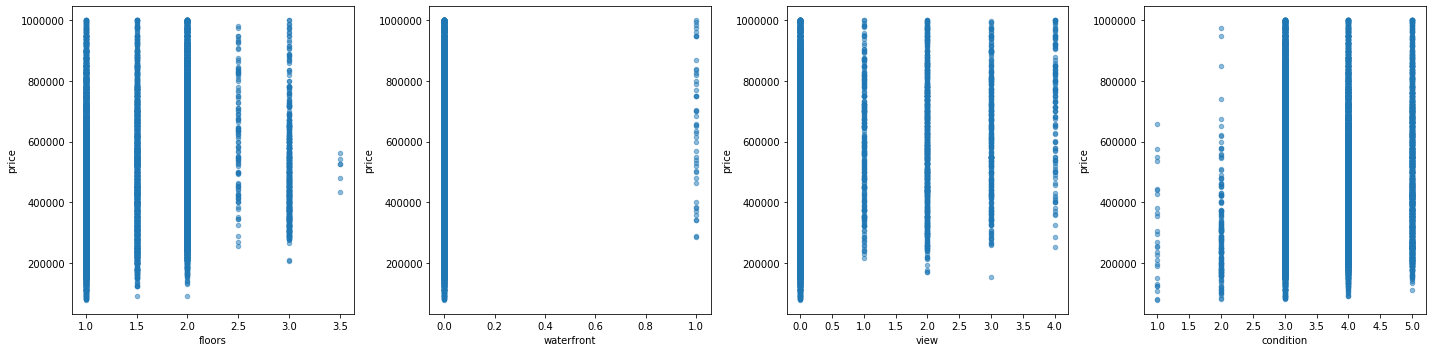

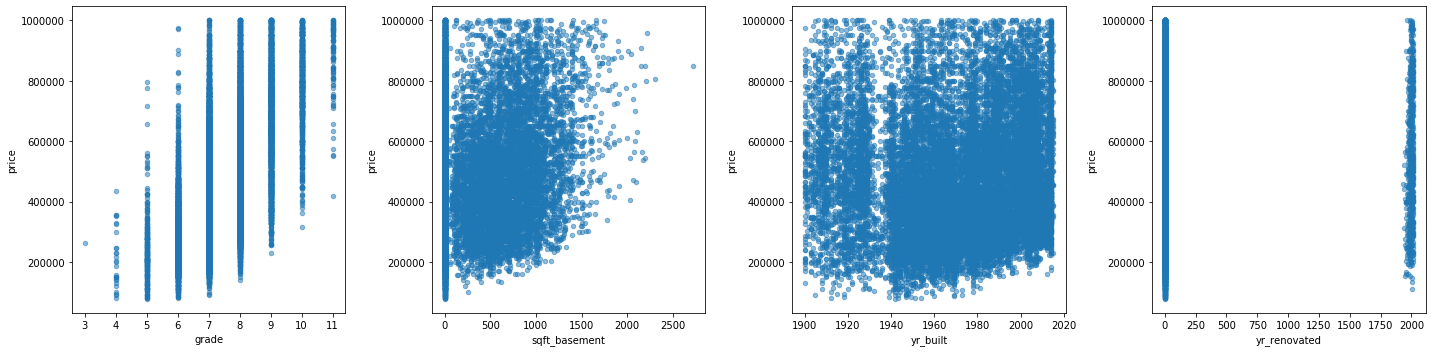

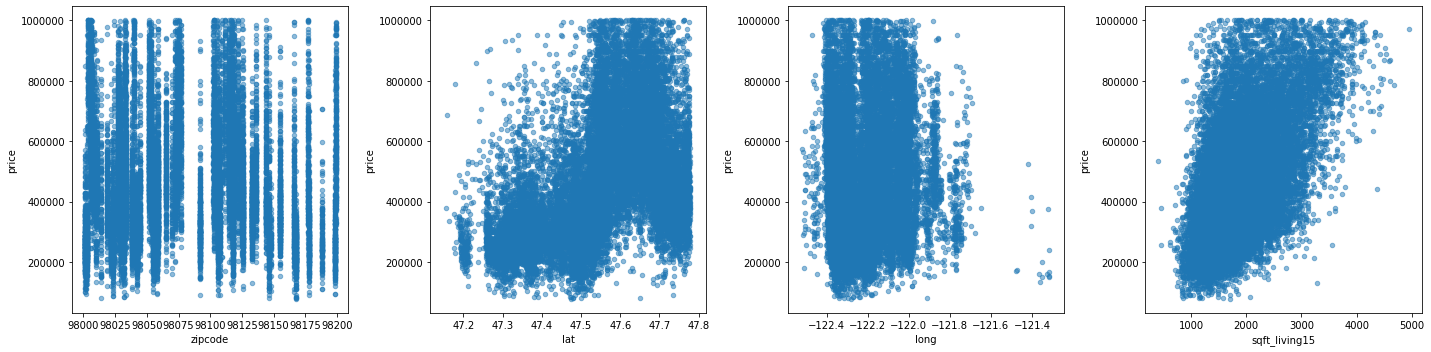

In [78]:
# evaluate variables that do not meet linearity requirement
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')
plot_x_y(['grade', 'sqft_basement', 'yr_built', 'yr_renovated'], 'price')
plot_x_y(['zipcode', 'lat', 'long', 'sqft_living15'], 'price')

In [79]:
# columns that meet linearity requirement
linearity_req = ['sqft_living15', 'sqft_basement', 'sqft_living']

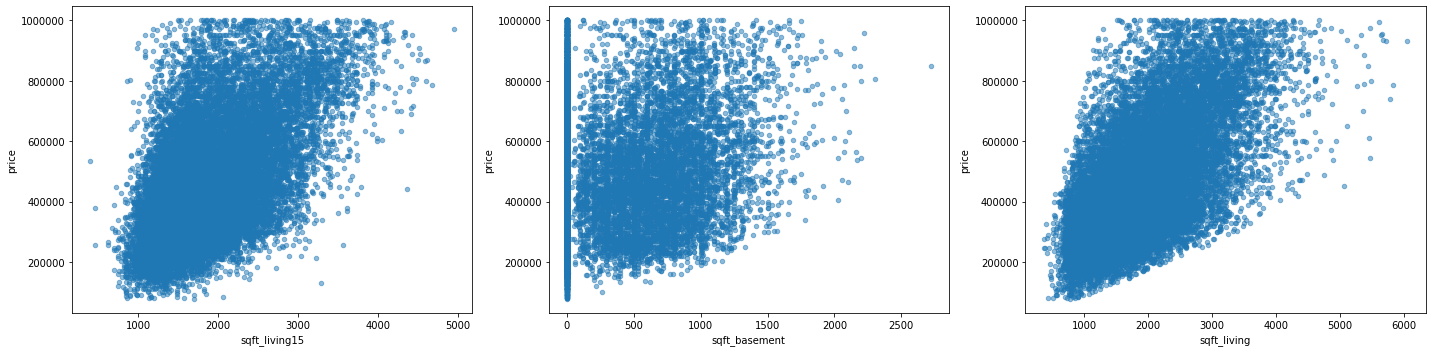

In [80]:
# plot all linear columns against price
plot_x_y(['sqft_living15', 'sqft_basement', 'sqft_living'], 'price')

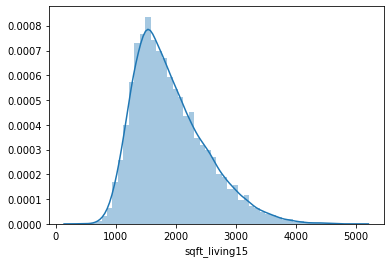

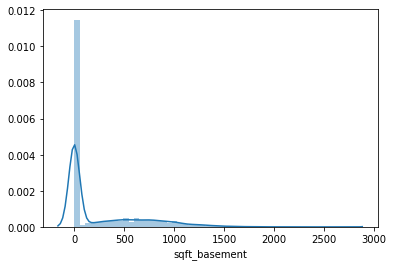

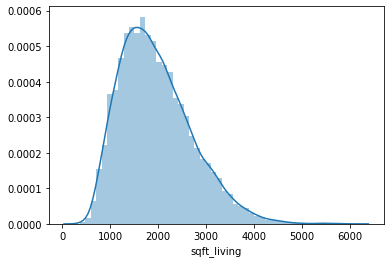

In [81]:
# evaluate the distributions of each to see if we need to log transform
# scales appear to be in line with each other -- and all are in square feet so no normalization will be required
for x_col in linearity_req:
    sns.distplot(houses_data[x_col]);
    plt.show()

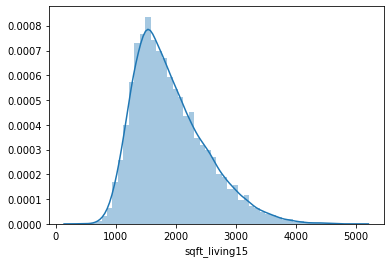

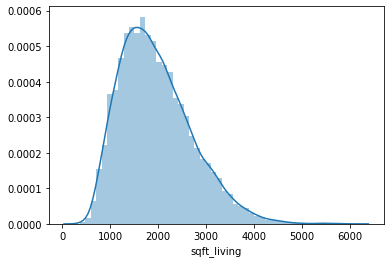

In [82]:
# given 0 values for basement - - will ignore this variable for the time being
linearity_req = ['sqft_living15', 'sqft_living']
for x_col in linearity_req:
    sns.distplot(houses_data[x_col]);
    plt.show()

In [83]:
# all have right skew and would likely benefit from log transformation - - log transform all three
# will reevaluate the basement later

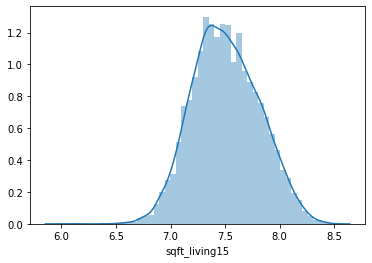

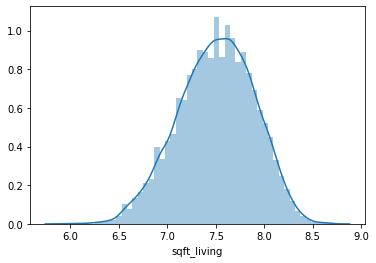

In [84]:
for x_col in linearity_req:
    houses_data[x_col] = houses_data[x_col].map(lambda x: np.log(x))
    
    
# plot again
for x_col in linearity_req:
    sns.distplot(houses_data[x_col]);
    plt.show()

In [85]:
# distributions are looking much more normal now

In [86]:
preprocessed = houses_data[['sqft_living15', 'sqft_living', 'price', 'bedrooms', 'grade']]
preprocessed.head()

,sqft_living15,sqft_living,price,bedrooms,grade
0,7.200425,7.073270,221900.0,3,7
1,7.432484,7.851661,538000.0,3,7
2,7.908387,6.646391,180000.0,2,6
3,7.215240,7.580700,604000.0,4,7
4,7.495542,7.426549,510000.0,3,8


In [87]:
preprocessed = pd.concat([preprocessed, bath_dummies, floor_dummies, cond_dummies, water_dummies, view_dummies],
                         axis=1)

In [88]:
preprocessed.head()

,sqft_living15,sqft_living,price,bedrooms,grade,bath_0.75,bath_1.0,bath_1.25,bath_1.5,bath_1.75,...,floor_3.5,cond_2,cond_3,cond_4,cond_5,water_1.0,view_1.0,view_2.0,view_3.0,view_4.0
0,7.200425,7.073270,221900.0,3,7,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,7.432484,7.851661,538000.0,3,7,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,7.908387,6.646391,180000.0,2,6,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7.215240,7.580700,604000.0,4,7,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,7.495542,7.426549,510000.0,3,8,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [89]:
preprocessed.columns

Index(['sqft_living15', 'sqft_living', 'price', 'bedrooms', 'grade',
       'bath_0.75', 'bath_1.0', 'bath_1.25', 'bath_1.5', 'bath_1.75',
       'bath_2.0', 'bath_2.25', 'bath_2.5', 'bath_2.75', 'bath_3.0',
       'bath_3.25', 'bath_3.5', 'bath_3.75', 'bath_4.0', 'bath_4.25',
       'bath_4.5', 'bath_4.75', 'bath_5.0', 'floor_1.5', 'floor_2.0',
       'floor_2.5', 'floor_3.0', 'floor_3.5', 'cond_2', 'cond_3', 'cond_4',
       'cond_5', 'water_1.0', 'view_1.0', 'view_2.0', 'view_3.0', 'view_4.0'],
      dtype='object')

In [90]:
# separate out X and y
X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

In [91]:
# run OLS to check the p-values, and statistical significance of 
# different variables

In [92]:
import statsmodels.api as sm
predictors_int = sm.add_constant(X)
model = sm.OLS(preprocessed['price'], predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     546.8
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:41:52   Log-Likelihood:            -2.6031e+05
No. Observations:               19632   AIC:                         5.207e+05
Df Residuals:                   19595   BIC:                         5.210e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.876e+06    9.2e+04    -20.401      0.000   -2.06e+06    -1.7e+06
sqft_living15  9.459e+04   5054.036     18.715      0.000    8.47e+04    1.04e+05
sqft_living    1.438e+05   5369.975     26.782      0.000    1.33e+05    1.54e+05
bedrooms      -1.409e+04   1525.774     -9.235      0.000   -1.71e+04   -1.11e+04
grade          7.844e+04   1553.172     50.503      0.000    7.54e+04    8.15e+04
bath_0.75      5.956e+04   8.19e+04      0.728      0.467   -1.01e+05     2.2e+05
bath_1.0       1.481e+04   8.02e+04      0.185      0.854   -1.42e+05    1.72e+05
bath_1.25     -2.418e+04   9.59e+04     -0.252      0.801   -2.12e+05    1.64e+05
bath_1.5      -1.884e+04   8.03e+04     -0.235      0.815   -1.76e+05    1.39e+05
bath_1.75     -1.627e+04   8.03e+04     -0.203      0.839   -1.74e+05    1.41e+05
bath_2.0      -1.211e+04   8.03e+04     -0.151      0.880    -1.7e+05    1.45e+05
bath_2.25      -3.09e+04   8.03e+04     -0.385      0.701   -1.88e+05    1.27e+05
bath_2.5      -4.721e+04   8.03e+04     -0.588      0.557   -2.05e+05     1.1e+05
bath_2.75     -4833.4715   8.04e+04     -0.060      0.952   -1.63e+05    1.53e+05
bath_3.0        894.7821   8.05e+04      0.011      0.991   -1.57e+05    1.59e+05
bath_3.25      1.817e+04   8.07e+04      0.225      0.822    -1.4e+05    1.76e+05
bath_3.5       2.307e+04   8.06e+04      0.286      0.775   -1.35e+05    1.81e+05
bath_3.75      7.375e+04   8.22e+04      0.898      0.369   -8.73e+04    2.35e+05
bath_4.0       5.149e+04   8.24e+04      0.625      0.532    -1.1e+05    2.13e+05
bath_4.25      7.641e+04   8.55e+04      0.893      0.372   -9.12e+04    2.44e+05
bath_4.5       3.755e+04   8.33e+04      0.451      0.652   -1.26e+05    2.01e+05
bath_4.75      7.411e+04   1.06e+05      0.697      0.486   -1.34e+05    2.82e+05
bath_5.0      -6.012e+04   9.85e+04     -0.610      0.542   -2.53e+05    1.33e+05
floor_1.5      7.855e+04   3673.164     21.385      0.000    7.13e+04    8.57e+04
floor_2.0        83.1265   2933.649      0.028      0.977   -5667.075    5833.328
floor_2.5       7.03e+04   1.38e+04      5.081      0.000    4.32e+04    9.74e+04
floor_3.0      6.291e+04   6662.844      9.442      0.000    4.99e+04     7.6e+04
floor_3.5      6.927e+04   5.68e+04      1.219      0.223   -4.21e+04    1.81e+05
cond_2        -1.827e+04   2.89e+04     -0.632      0.527   -7.49e+04    3.84e+04
cond_3          843.1525   2.69e+04      0.031      0.975   -5.19e+04    5.35e+04
cond_4          2.85e+04   2.69e+04      1.059      0.289   -2.42e+04    8.12e+04
cond_5         8.437e+04   2.71e+04      3.115      0.002    3.13e+04    1.37e+05
water_1.0      7.095e+04    2.3e+04      3.085      0.002    2.59e+04    1.16e+05
view_1.0       8.172e+04   8791.849      9.296      0.000    6.45e+04     9.9e+04
view_2.0       6.044e+04   5288.194     11.429   